In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers

In [ ]:
class MLP(layers.Layer):
    def __init__(self, outsize):
        super().__init__()
        self.layer_1 = layers.Dense(outsize, activation=tf.nn.gelu)
        self.layer_2 = layers.Dense(outsize)

    def call(self, inputs):
        h = self.layer_1(inputs)
        return self.layer_2(h)

class Mixer(layers.Layer):
    def __init__(self, outheight, outwidth):
        super().__init__()
        self.layer_1 = MLP(outheight)
        self.layer_2 = MLP(outwidth)

    def call(self, inputs):
        h = tf.keras.layers.Permute((2, 1))(inputs)
        h = self.layer_1(h)
        h = tf.keras.layers.Permute((2, 1))(h)
        return self.layer_2(h)

class ScalarGate(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.value = tf.Variable(0.0, trainable=True)

    def call(self, inputs):
        return self.value * inputs

def patchless_mixer(height, width, num_classes, num_mix_layers, name=None):
    inputs = tf.keras.layers.Input(shape=(height, width))
    
    h = inputs
    for i in range(num_mix_layers):
        h = ScalarGate()(Mixer(height, width)(h)) + h
    
    # Classification:
    # Rather than average pooling, use MLP for rows, and then cols, then concat.
    rows_out = MLP(1)(h)
    rows_out = tf.keras.layers.Lambda(lambda x: x[:, :, 0])(rows_out)

    cols_out = tf.keras.layers.Permute((2, 1))(h)
    cols_out = MLP(1)(cols_out)
    cols_out = tf.keras.layers.Lambda(lambda x: x[:, :, 0])(cols_out)

    concat = tf.keras.layers.Concatenate()([rows_out, cols_out])
    flat = tf.keras.layers.Flatten()(concat)
    y = tf.keras.layers.Dense(num_classes)(flat)
    return tf.keras.Model(inputs=inputs, outputs=y, name=name)


def autoencoder(height, width, num_classes, num_mix_layers, name=None):
    """Autoencoder via mixer layers. Note, skip connections aren't used here, 
    otherwise network is trivially the identity function."""
    inputs = tf.keras.layers.Input(shape=(height, width))
    
    h = inputs
    for i in range(num_mix_layers):
        h = Mixer(height, width)(h)

    return tf.keras.Model(inputs=inputs, outputs=h, name=name)


# MNIST

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)

height, width = train_images.shape[-2:]
num_classes = 10

## Classifier

In [ ]:
num_mix_layers = 16
model = patchless_mixer(height, width, num_classes, num_mix_layers)
# print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
938/938 [==============================] - 38s 33ms/step - loss: 0.8026 - accuracy: 0.7325 - val_loss: 0.1206 - val_accuracy: 0.9625
Epoch 2/10
938/938 [==============================] - 29s 31ms/step - loss: 0.1205 - accuracy: 0.9631 - val_loss: 0.0977 - val_accuracy: 0.9706
Epoch 3/10
938/938 [==============================] - 29s 31ms/step - loss: 0.0798 - accuracy: 0.9750 - val_loss: 0.0754 - val_accuracy: 0.9760
Epoch 4/10
938/938 [==============================] - 29s 31ms/step - loss: 0.0613 - accuracy: 0.9808 - val_loss: 0.0728 - val_accuracy: 0.9768
Epoch 5/10
938/938 [==============================] - 29s 31ms/step - loss: 0.0498 - accuracy: 0.9847 - val_loss: 0.0653 - val_accuracy: 0.9795
Epoch 6/10
938/938 [==============================] - 29s 31ms/step - loss: 0.0375 - accuracy: 0.9880 - val_loss: 0.0650 - val_accuracy: 0.9802
Epoch 7/10
938/938 [==============================] - 29s 31ms/step - loss: 0.0283 - accuracy: 0.9911 - val_loss: 0.0707 - val_accuracy:

313/313 - 5s - loss: 0.0636 - accuracy: 0.9836


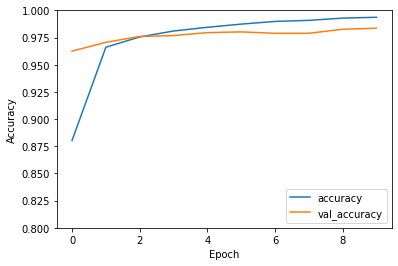

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.8, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## Autoencoder

Note skip connections aren't used for the autoencoder, because they cause the network to be initialised as the identify function.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
mixer_16 (Mixer)             (None, 28, 28)            3248      
_________________________________________________________________
mixer_17 (Mixer)             (None, 28, 28)            3248      
Total params: 6,496
Trainable params: 6,496
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
938/938 [==============================] - 6s 5ms/step - loss: 0.0357 - root_mean_squared_error: 0.1813 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0022 - root_mean_squared_error: 0.0468 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 3/10
938/938 [==================

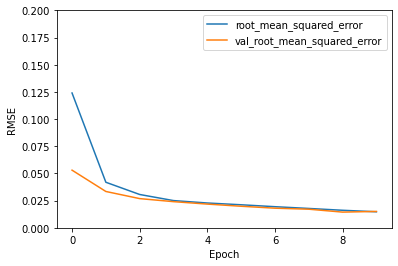

In [ ]:
num_mix_layers = 2
model = autoencoder(height, width, num_classes, num_mix_layers)
print(model.summary())

model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_images, train_images, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_images))

plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, .2])
plt.legend()
test_loss, test_acc = model.evaluate(test_images,  test_images, verbose=2)

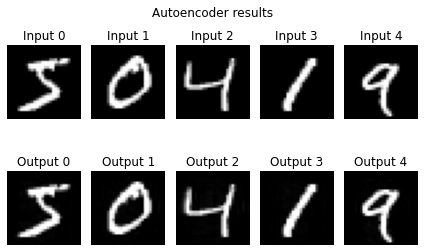

In [ ]:
for i in range(5):
    im = train_images[i:i+1,:,:]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results")
plt.tight_layout()
plt.show()

# CIFAR-10

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, test_images = train_images.astype(np.float32), test_images.astype(np.float32)
height, width, channels = 32, 32, 3
num_classes = 10

## Classifier

In [ ]:
num_mix_layers = 32
inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
model = patchless_mixer(height, width * channels, num_classes, num_mix_layers)(reshaped)
model = tf.keras.Model(inputs=inputs, outputs=model)
print(model.summary())
model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 96)            0         
_________________________________________________________________
model_2 (Functional)         (None, 10)                665008    
Total params: 665,008
Trainable params: 665,008
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 70s 70ms/step - loss: 1.8513 - accuracy: 0.3229 - val_loss: 1.3484 - val_accuracy: 0.5215
Epoch 2/10
782/782 [==============================] - 53s 67ms/step - loss: 1.2987 - accuracy: 0.5391 - val_loss: 1.2271 - val_accuracy: 0.5581
Epoch 3/10
782/782 [==============================] - 52s 67ms/step - loss: 1.1233 - accur

313/313 - 10s - loss: 1.8549 - accuracy: 0.5945


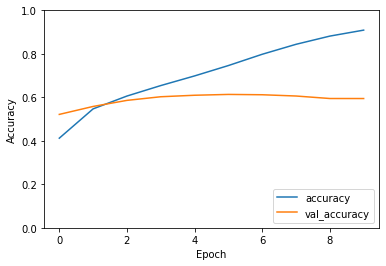

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## Autoencoder

Note skip connections aren't used for the autoencoder, because they cause the network to be initialised as the identify function.

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 96)            0         
_________________________________________________________________
model_4 (Functional)         (None, 32, 96)            41472     
_________________________________________________________________
reshape_2 (Reshape)          (None, 32, 32, 3)         0         
Total params: 41,472
Trainable params: 41,472
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
782/782 [==============================] - 7s 7ms/step - loss: 0.0494 - root_mean_squared_error: 0.2086 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 0.

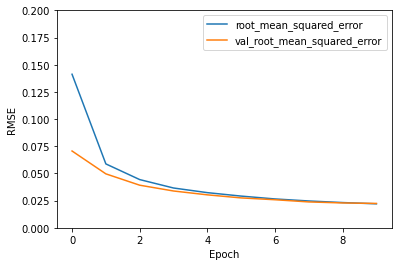

In [11]:
num_mix_layers = 2

inputs = tf.keras.layers.Input(shape=(height, width, channels))
reshaped = tf.keras.layers.Reshape([height, width * channels])(inputs)
model = autoencoder(height, width * channels, num_classes, num_mix_layers)(reshaped)
model = tf.keras.layers.Reshape([height, width, channels])(model)
model = tf.keras.Model(inputs=inputs, outputs=model)
print(model.summary())

model.predict(train_images[:2, :, :])
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_images, train_images, batch_size=64, epochs=10, 
                    validation_data=(test_images, test_images))

plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, .2])
plt.legend()
test_loss, test_acc = model.evaluate(test_images,  test_images, verbose=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


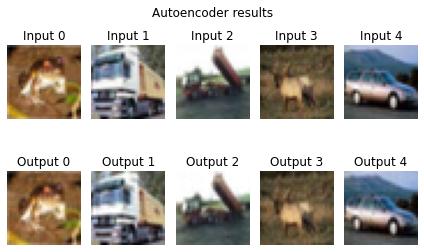

In [12]:
for i in range(5):
    im = train_images[i:i+1,:,:]

    plt.subplot(2, 5, i+1)
    plt.imshow(im[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Input {i}')

    plt.subplot(2, 5, i+6)
    plt.imshow(model.predict(im)[0,:,:], cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Output {i}')

plt.suptitle("Autoencoder results")
plt.tight_layout()
plt.show()